In [1]:
import numpy as np
import tensorflow as tf
import tqdm, os
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as displayer
import math
#import random

#reference: https://gist.github.com/tomokishii/0ce3bdac1588b5cca9fa5fbdf6e1c412
#           https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py

class Config(object):
    pass
config = Config()
config.batch_size = 128
config.use_float16 = False
config.data_path_dir = "../../../datasets/cifar-10-batches-bin"
config.BN_epsilon = 1e-5
config.BN_decay = 0.995

In [2]:
class Dataset():
    def __init__(self, batch_size = config.batch_size):
        self.width = 32
        self.height = 32
        self.depth = 3
        self.x_train, self.y_train = None, None
        self.x_test, self.y_test = None, None
        self.batch_size = batch_size
        self.num_classes = 10
        
    def readData(self, path, is_one_hot = True):
        y_train, y_test = None, None
        for i in range(1, 6):
            with open(os.path.join(path, "data_batch_%d.bin" %i), mode='rb') as file:
                t = np.fromfile(file, dtype = np.uint8).reshape(10000, -1)
                file.close()
                y = t[:, 0]
                x = t[:, 1:] / 255.0
                if self.x_train is None: self.x_train = x
                else: self.x_train = np.concatenate((self.x_train, x))

                if y_train is None: y_train = y
                else: y_train = np.concatenate((y_train, y))
        
        self.start_batch_index = self.end_batch_index = self.num_train_images = np.shape(y_train)[0]
        
        with open(os.path.join(path, "test_batch.bin"), mode='rb') as file:
            t = np.fromfile(file, dtype = np.uint8).reshape(10000, -1)
            y_test = t[:, 0]
            self.x_test = t[:, 1:] / 255.0
        
        ## change labels to one-hot type:
        if is_one_hot:
            self.y_train = np.zeros((self.num_train_images, self.num_classes))
            self.y_train[np.arange(self.num_train_images), y_train] = 1
            self.y_test = np.zeros((10000, self.num_classes))
            self.y_test[np.arange(10000), y_test] = 1
        else:
            self.y_train = y_train#.reshape(np.shape(y_train)[0], 1)
            self.y_test = y_test#.reshape(np.shape(y_test)[0], 1)
        
    def get_next_batch(self):
        if self.end_batch_index >= self.num_train_images:
            #suffle
            self.suffle()
            self.start_batch_index = 0
            self.end_batch_index = self.batch_size
        
        batch_x = self.x_train[self.start_batch_index : self.end_batch_index].astype(
            np.float16 if config.use_float16 else np.float32)
        batch_y = self.y_train[self.start_batch_index : self.end_batch_index]
        self.start_batch_index = self.end_batch_index
        self.end_batch_index += self.batch_size
        
        return (batch_x, batch_y)
    
    
    def suffle(self, is_training = True):
        if is_training:
            perm = np.random.permutation(self.num_train_images)
            self.x_train = self.x_train[perm]
            self.y_train = self.y_train[perm]
        else:
            perm = np.random.permutation(10000)
            self.x_test = self.x_test[perm]
            self.y_test = self.y_test[perm]
            
            
dataset = Dataset()
dataset.readData(config.data_path_dir, is_one_hot = False)# this is a simpler version of Tensorflow's 'official' version. See:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/layers/python/layers/layers.py#L102


In [3]:
def batch_norm_wrapper(x, is_training, step):
    """
    is_training: a boolean tensor
    """
    with tf.variable_scope('batch_norm') as scope:
        gamma = tf.Variable(tf.ones([x.get_shape()[-1]]), trainable = True)
        beta  = tf.Variable(tf.zeros([x.get_shape()[-1]]), trainable = False)
        pop_mean = tf.Variable(tf.zeros([x.get_shape()[-1]]), trainable=False, name = "pop_mean")
        pop_var  = tf.Variable(tf.ones([x.get_shape()[-1]]), trainable=False, name = "pop_var")

    def using_batch_statistics():
        batch_mean, batch_var = tf.nn.moments(x,[0])
        train_mean = tf.assign(pop_mean,
                               pop_mean * config.BN_decay + batch_mean * (1 - config.BN_decay))
        train_var = tf.assign(pop_var,
                              pop_var * config.BN_decay + batch_var * (1 - config.BN_decay))
        
#         train_mean = tf.cond(tf.greater(step, 5000), lambda: pop_mean, lambda: batch_mean)
#         train_var = tf.cond(tf.greater(step, 5000), lambda: pop_var, lambda: batch_var)
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(x,
                batch_mean, batch_var, beta, gamma, config.BN_epsilon)

#             return tf.cond(tf.greater(step, 5000), lambda: tf.nn.batch_normalization(x,
#                                                 pop_mean, pop_var, beta, gamma, config.BN_epsilon),
#                                             lambda: tf.nn.batch_normalization(x,
#                                                 pop_mean, pop_var, beta, gamma, config.BN_epsilon))
#         def f1():
#             return tf.nn.batch_normalization(x,
#                 batch_mean, batch_var, beta, gamma, config.BN_epsilon)
#         def f2():
#         tf.cond(tf.greater(step, 5000)
#         inv = tf.rsqrt(tf.add(train_var, 1e-4)) * gamma
#         x * inv + (beta - train_mean * inv)
                       
        
    def using_global_statistics():
        return tf.nn.batch_normalization(x,
            pop_mean, pop_var, beta, gamma, config.BN_epsilon)
    
    return tf.cond(is_training, 
                   using_batch_statistics, 
                   using_global_statistics)

def variable_on_gpu(name, shape, initializer):
    with tf.device('/gpu:0'):
        dtype = tf.float16 if config.use_float16 else tf.float32
        var = tf.get_variable(name, shape, initializer=initializer, dtype=dtype)
    return var

def variable_with_weight_decay(name, shape, stddev, wd):
    dtype = tf.float16 if config.use_float16 else tf.float32
    var = variable_on_gpu(
        name,
        shape,
        tf.truncated_normal_initializer(stddev=stddev, dtype=dtype))
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var

layer_sizes = [3*32*32, 100, 100, 100, 100, 100, 10]
# w1_initial = np.random.normal(loc=0, scale=1/layer_sizes[0], 
#                               size = (layer_sizes[0], layer_sizes[1])).astype(np.float32)
# w2_initial = np.random.normal(loc=0, scale=1/layer_sizes[1],
#                               size = (layer_sizes[1], layer_sizes[2])).astype(np.float32)
# w3_initial = np.random.normal(loc=0, scale=1/layer_sizes[2],
#                               size = (layer_sizes[2], layer_sizes[3])).astype(np.float32)
# w4_initial = np.random.normal(loc=0, scale=1/layer_sizes[3], 
#                               size = (layer_sizes[3], layer_sizes[4])).astype(np.float32)
# w5_initial = np.random.normal(loc=0, scale=1/layer_sizes[4], 
#                               size = (layer_sizes[4], layer_sizes[5])).astype(np.float32)
# w6_initial = np.random.normal(loc=0, scale=1/layer_sizes[6], 
#                               size = (layer_sizes[5], layer_sizes[6])).astype(np.float32)

w1_initial = np.random.normal(loc=0, scale=1, 
                              size = (layer_sizes[0], layer_sizes[1])).astype(np.float32)
w2_initial = np.random.normal(loc=0, scale=1,
                              size = (layer_sizes[1], layer_sizes[2])).astype(np.float32)
w3_initial = np.random.normal(loc=0, scale=1,
                              size = (layer_sizes[2], layer_sizes[3])).astype(np.float32)
w4_initial = np.random.normal(loc=0, scale=1, 
                              size = (layer_sizes[3], layer_sizes[4])).astype(np.float32)
w5_initial = np.random.normal(loc=0, scale=1, 
                              size = (layer_sizes[4], layer_sizes[5])).astype(np.float32)
w6_initial = np.random.normal(loc=0, scale=1, 
                             size = (layer_sizes[5], layer_sizes[6])).astype(np.float32)


# w1_initial = np.random.rand(layer_sizes[0], layer_sizes[1]).astype(np.float32)
# w2_initial = np.random.rand(layer_sizes[1], layer_sizes[2]).astype(np.float32)
# w3_initial = np.random.rand(layer_sizes[2], layer_sizes[3]).astype(np.float32)
# w4_initial = np.random.rand(layer_sizes[3], layer_sizes[4]).astype(np.float32)
# w5_initial = np.random.rand(layer_sizes[4], layer_sizes[5]).astype(np.float32)
# w6_initial = np.random.rand(layer_sizes[5], layer_sizes[6]).astype(np.float32)

In [4]:
def build_graph(is_using_BN = True):
    # Placeholders
    dtype = tf.float16 if config.use_float16 else tf.float32
    #x = tf.placeholder(dtype, shape=[None, dataset.height, dataset.width, dataset.depth])
    y = tf.placeholder(tf.int32)
    x = tf.placeholder(tf.float32, shape=[None, layer_sizes[0]])
    #y = tf.placeholder(tf.float32, shape=[None, layer_sizes[-1]])
    is_training = tf.placeholder(tf.bool)
    global_step = tf.Variable(0, trainable=False)
    # Layer 1
    #xx = batch_norm_wrapper(x, is_training)
    with tf.variable_scope('layer1') as scope:
        w1 = tf.Variable(w1_initial)
        z1 = tf.matmul(x, w1)
        if is_using_BN:
            bn1 = batch_norm_wrapper(z1, is_training, global_step)
            o1 = tf.sigmoid(bn1)
        else:
            b1 = tf.Variable(tf.zeros([layer_sizes[1]]))
            z1 = tf.nn.bias_add(z1, b1)
            o1 = tf.sigmoid(z1)
#         if is_using_BN:
#             o1 = batch_norm_wrapper(o1, is_training, global_step)
    
    # Layer 2
    with tf.variable_scope('layer2') as scope:
        w2 = tf.Variable(w2_initial)
        z2 = tf.matmul(o1, w2)
        if is_using_BN:
            bn2 = batch_norm_wrapper(z2, is_training, global_step)
            o2 = tf.sigmoid(bn2)
        else:
            b2 = tf.Variable(tf.zeros([layer_sizes[2]]))
            z2 = tf.nn.bias_add(z2, b2)
            o2 = tf.sigmoid(z2)
    
    # Layer 3
    with tf.variable_scope('layer3') as scope:
        w3 = tf.Variable(w3_initial, name='w3')
        z3 = tf.matmul(o2, w3)
        if is_using_BN:
            bn3 = batch_norm_wrapper(z3, is_training, global_step)
            o3 = tf.sigmoid(bn3)
        else:
            b3 = tf.Variable(tf.zeros([layer_sizes[3]]))
            z3 = tf.nn.bias_add(z3, b3)
            o3 = tf.sigmoid(z3)
        
    
    # Softmax
#     with tf.variable_scope('layer4') as scope:
#         w4 = tf.Variable(w4_initial, name='w4')
#         z4 = tf.matmul(o3, w4)
#         if is_using_BN:
#             bn4 = batch_norm_wrapper(z4, is_training, global_step)
#             o4 = tf.sigmoid(bn4)
#         else:
#             b4 = tf.Variable(tf.zeros([layer_sizes[4]]))
#             z4 = tf.nn.bias_add(z4, b4)
#             o4 = tf.sigmoid(z4)
            
#     with tf.variable_scope('layer4') as scope:
#         w5 = tf.Variable(w5_initial, name='w5')
#         z5 = tf.matmul(o3, w5)
#         if is_using_BN:
#             bn5 = batch_norm_wrapper(z5, is_training, global_step)
#             o5 = tf.sigmoid(bn5)
#         else:
#             b5 = tf.Variable(tf.zeros([layer_sizes[5]]))
#             z5 = tf.nn.bias_add(z5, b5)
#             o5 = tf.sigmoid(z5)
        
    with tf.variable_scope('softmax') as scope:
        w6 = tf.Variable(w6_initial)
        b6 = tf.Variable(tf.zeros([layer_sizes[-1]]))
        o6 = y_out = tf.nn.bias_add(tf.matmul(o3, w6), b6)

    # Loss, Optimizer and Predictions
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y, logits=y_out, name='cross_entropy')
    
    tf.add_to_collection('losses', tf.reduce_mean(cross_entropy))
    total_loss = tf.add_n(tf.get_collection('losses'), name='total_loss')
    
#     do1 = tf.reduce_mean(tf.abs(tf.gradients(total_loss, o1)))
#     do2 = tf.reduce_mean(tf.abs(tf.gradients(total_loss, o2)))
#     do3 = tf.reduce_mean(tf.abs(tf.gradients(total_loss, o3)))
#     do4 = tf.reduce_mean(tf.abs(tf.gradients(total_loss, o4)))
    
    do1 = tf.Variable(0)#tf.reduce_mean(tf.multiply(o1, (1 - o1)))
    do2 = tf.Variable(0)#tf.reduce_mean(tf.multiply(o2, (1 - o2)))
    do3 = tf.Variable(0)#tf.reduce_mean(tf.multiply(o3, (1 - o3)))
    do4 = tf.Variable(0)#tf.reduce_mean(tf.multiply(o4, (1 - o4)))
    do5 = tf.Variable(0)#tf.reduce_mean(tf.multiply(o5, (1 - o5)))
    
    z1_mean = tf.reduce_mean(tf.abs(z1))
    batch_var = tf.reduce_mean(tf.get_collection("batch_mean"))
    
    #batch_var = tf.reduce_mean(tf.add_n(batchvar))
    #batch_var = [v.name for v in tf.global_variables()]
    dw1 = tf.Variable(0)#tf.reduce_mean(tf.abs(tf.gradients(total_loss, w1)))
    dw2 = tf.Variable(0)#tf.reduce_mean(tf.abs(tf.gradients(total_loss, w2)))
    dw3 = tf.Variable(0)#tf.reduce_mean(tf.abs(tf.gradients(total_loss, w3)))
    dw4 = tf.Variable(0)#tf.reduce_mean(tf.abs(tf.gradients(total_loss, w4)))
    dw5 = tf.Variable(0)#tf.reduce_mean(tf.abs(tf.gradients(total_loss, w5)))
    
#     learning_rate = tf.train.exponential_decay(config.learning_rate, global_step,
#                                            2000, 0.96, staircase=True)

    trainer = tf.train.GradientDescentOptimizer(learning_rate = config.learning_rate).minimize(total_loss, global_step = global_step)

    correct_prediction = tf.equal(tf.cast(tf.arg_max(y_out, 1), tf.int32), y)
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return (x, y, is_training), (do1, do2, do3, do4, do5), (dw1, dw2, dw3, dw4, dw5), trainer, acc, total_loss, y_out, tf.train.Saver()

In [5]:
def train(is_using_BN = True,
          is_continue = False,
          model_name = None,
          current_step = 0,
          max_steps = 200000,
          eval_interval = 500,
          save_interval = 50000):
    
    graph = tf.Graph()
    with graph.as_default():
        (x_train, y_train, is_training), (Do1, Do2, Do3, Do4, Do5), (Dw1, Dw2, Dw3, Dw4, Dw5), trainer, accuracy, loss, y_out, saver = \
        build_graph(is_using_BN)
    
    
    if is_continue:
        """load something"""
        f = open(os.path.join(config.store_path, "losses.bin"), "rb")
        losses = np.fromfile(f, dtype = np.float32)
        f.close()
        f = open(os.path.join(config.store_path, "train_acc.bin"), "rb")
        train_acc = np.fromfile(f, dtype = np.float32)
        f.close()
        f = open(os.path.join(config.store_path, "test_acc.bin"), "rb")
        test_acc = np.fromfile(f, dtype = np.float32)
        f.close()
    else:
        losses, train_acc, test_acc = np.array([], dtype = np.float32), np.array([], dtype = np.float32), np.array([], dtype = np.float32)
        do1s, do2s, do3s, do4s, do5s = np.array([], dtype = np.float32), np.array([], dtype = np.float32), np.array([], dtype = np.float32), np.array([], dtype = np.float32), np.array([], dtype = np.float32)
        dw1s, dw2s, dw3s, dw4s, dw5s = np.array([], dtype = np.float32), np.array([], dtype = np.float32), np.array([], dtype = np.float32), np.array([], dtype = np.float32), np.array([], dtype = np.float32)
    
    def evaluate(sess, num_examples = 5000, is_on_training_set = True): 
        accs = []
        if is_on_training_set:
            prem = np.random.permutation(dataset.num_train_images)
            x = dataset.x_train[prem[:num_examples]]
            y = dataset.y_train[prem[:num_examples]]
        else:
            x = dataset.x_test[:num_examples]
            y = dataset.y_test[:num_examples]
        
        for i in range(0, num_examples, 500):
            res = sess.run([accuracy],
                           feed_dict = {x_train: x[i : i + 500],
                                        y_train: y[i : i + 500], 
                                        is_training: False})
            accs.append(res[0])
        
        return sum(accs) / len(accs)
 
    def save(arr, name):
        f = open(os.path.join(config.store_path, name), "wb")
        arr.tofile(f)
        f.close()
        
    with tf.Session(graph = graph) as sess:
        if is_continue:
            if model_name is None:
                raise ValueError('Need the name of model')
            saver = tf.train.import_meta_graph(os.path.join(config.store_path, model_name + '.meta'))
            saver.restore(sess, os.path.join(config.store_path, model_name))
        else:
            sess.run(tf.global_variables_initializer())
            
        # -----------------------------------------------------------------------------------------
        # training
        for i in tqdm.tqdm(range(current_step + 1, max_steps + 1)):
            batch = dataset.get_next_batch()
            _,l,(do1,do2,do3,do4,do5),(dw1,dw2,dw3,dw4,dw5) = sess.run([trainer, loss, (Do1, Do2, Do3, Do4, Do5), 
                                                                        (Dw1, Dw2, Dw3, Dw4, Dw5)], 
                                   feed_dict = {x_train : batch[0],
                                             y_train : batch[1],
                                             is_training : True})
            #losses.append(l)
#             popvar_FC1.append(pvfc1)
#             popmean_FC1.append(pmfc1)
            if i % save_interval == 0:
                saved_model = saver.save(sess, config.store_path + 'model.ckpt', i)
                save(do1s, 'do1.bin')
                save(do2s, 'do2.bin')
                save(do3s, 'do3.bin')
                save(do4s, 'do4.bin')
                save(do5s, 'do5.bin')
                save(dw1s, 'dw1.bin')
                save(dw2s, 'dw2.bin')
                save(dw3s, 'dw3.bin')
                save(dw4s, 'dw4.bin')
                save(dw5s, 'dw5.bin')
                save(losses, 'losses.bin')
                save(train_acc, 'train_acc.bin')
                save(test_acc, 'test_acc.bin')
                
            
            if i % eval_interval == 0:
                do1s=np.append(do1s, do1)
                do2s=np.append(do2s, do2)
                do3s=np.append(do3s, do3)
                do4s=np.append(do4s, do4)
                do5s=np.append(do5s, do5)
                dw1s=np.append(dw1s, dw1)
                dw2s=np.append(dw2s, dw2)
                dw3s=np.append(dw3s, dw3)
                dw4s=np.append(dw4s, dw4)
                dw5s=np.append(dw5s, dw5)
#                 w3s=w3s.append(w3)
                losses = np.append(losses, l)
                test_acc = np.append(test_acc, evaluate(sess, 10000, False)).astype(np.float32)
                train_acc = np.append(train_acc, evaluate(sess)).astype(np.float32)
                
                
                displayer.clear_output()
#                 print (np.mean(np.abs(dw1)))
#                 print (np.mean(np.abs(dw4)))
                print('test acc: ', test_acc[-1])
                print('train acc: ', train_acc[-1])
                print(dw1, dw2, dw3, dw4, dw5)
                print(do1, do2, do3, do4, do5)
                plt.figure(1)
                plt.plot(range(0, i, eval_interval), train_acc, 'red', range(0, i, eval_interval), test_acc, 'blue')
                plt.figure(2)
                plt.plot(range(0, i, eval_interval), losses)
#                 ax1 = plt.subplot(111)
#                 #plt.plot(np.arange(0, i, eval_interval), losses)
#                 #plt.figure(1)
#                 ax1.plot(range(0, i, eval_interval), train_acc, 'red', range(0, i, eval_interval), test_acc, 'blue')
#                 plt.figure(2)
#                 plt.plot(np.arange(0, i), popvar_FC1)
#                 plt.figure(3)
#                 plt.plot(np.arange(0, i), popmean_FC1)
                plt.show()
                
        
    return losses, train_acc, test_acc

In [ ]:
config.learning_rate = 2.0
config.store_path = "../../../models/MLP/cifar10/withoutBN/lr 2.0"
losses, train_acc, test_acc = train(is_using_BN = False)

  0%|                                                       | 181/200000 [00:01<1:23:32, 39.86it/s]

(800,) (800,) (800,)
test acc:  0.1
train acc:  0.0959000006318
dw3 mean:  15.8371


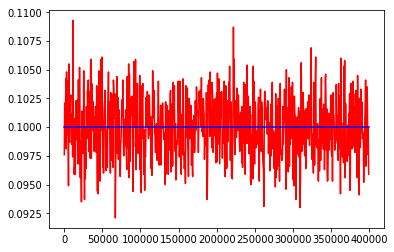

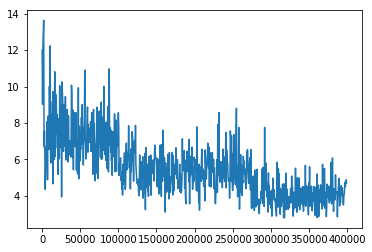

100%|███████████████████████████████████████████████████| 400000/400000 [1:00:31<00:00, 110.13it/s]


In [7]:
config.learning_rate = 4.0
config.store_path = "../../../models/MLP/cifar10/withoutBN/lr 4.0"
losses, train_acc, test_acc = train(is_using_BN = False)

test acc:  0.3732
train acc:  0.9166
0 0 0 0 0
0 0 0 0 0


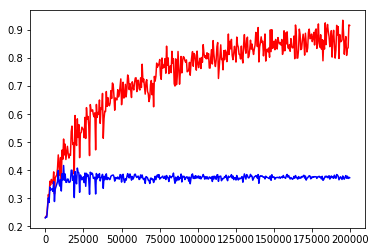

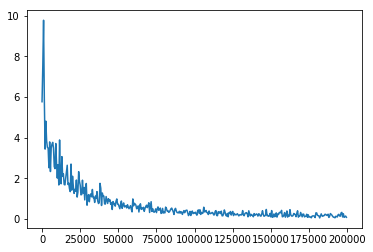

100%|██████████████████████████████████████████████████████| 200000/200000 [33:49<00:00, 98.53it/s]


In [6]:
config.learning_rate = 2.0
config.store_path = "../../../models/MLP/cifar10/withBN/lr 2.0"
losses, train_acc, test_acc = train(is_using_BN = True)

(4,) (4,) (4,)
test acc:  0.1116
train acc:  0.108499999717
dw3 mean:  67.2167


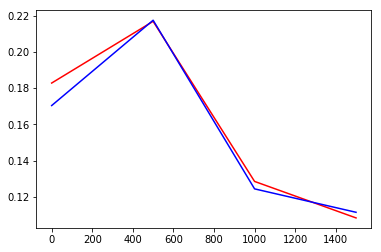

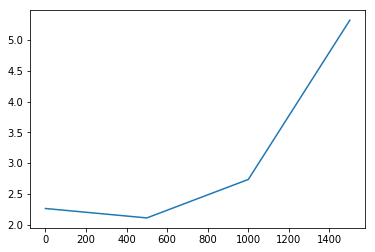

  1%|▎                                                      | 2406/400000 [00:24<49:25, 134.07it/s]

KeyboardInterrupt: 

In [9]:
config.learning_rate = 2.0
config.store_path = "../../../models/MLP/cifar10/withBN/lr 2.0"
losses, train_acc, test_acc = train(is_using_BN = True)

(800,) (800,) (800,)
test acc:  0.4451
train acc:  0.933000043035
dw3 mean:  23.9526


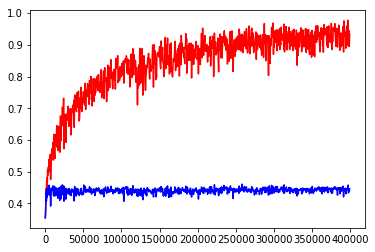

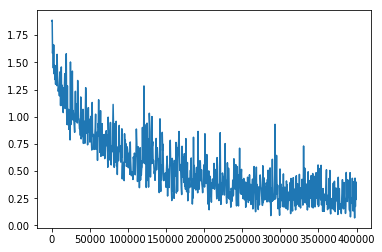

100%|████████████████████████████████████████████████████| 400000/400000 [1:16:02<00:00, 87.67it/s]


In [8]:
config.learning_rate = 10.0
config.store_path = "../../../models/MLP/cifar10/withBN/lr 10.0"
losses, train_acc, test_acc = train(is_using_BN = True)